In [1]:
from templates import *

In [2]:
device = 'cuda:1'
conf = ffhq128_autoenc_w_classifier()
conf.name = 'ffhq128_autoenc_w_classifier_weightedLoss_step_BN'
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0
Using cache found in /users/biocomp/mahanta/.cache/torch/hub/pytorch_vision_v0.10.0


Model params: 124.97 M


In [36]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = data[1]['img'][None]

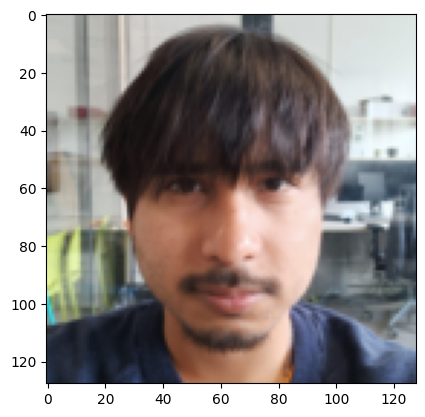

In [4]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

# Encode

In [5]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

In [6]:
cond.device

device(type='cuda', index=1)

In [7]:
xT.device

device(type='cuda', index=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.03674..7.0472283].


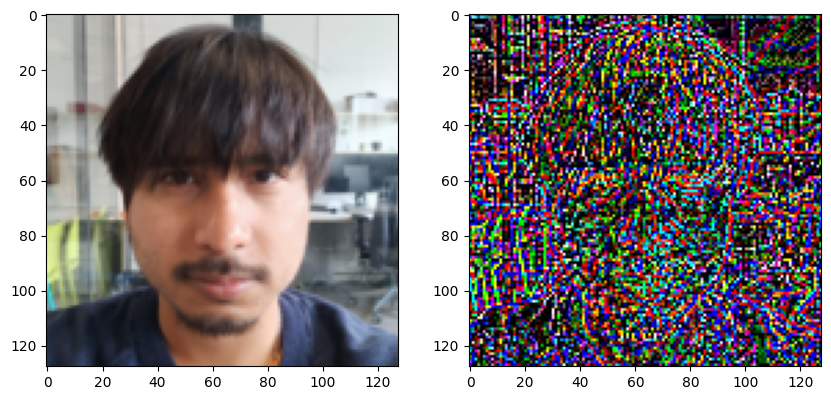

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

# Decode

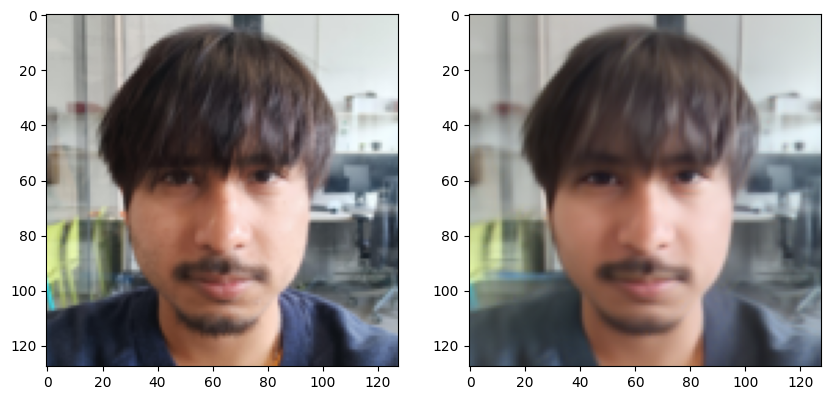

In [9]:
pred = model.render(xT, cond, T=20)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

# Decode with class_concatendated cond

In [15]:
modified_cond = model.ema_model.classifier_component(x = batch.to(device), cond = cond)

In [16]:
modified_xT = model.encode_stochastic(batch.to(device), modified_cond, T=250)

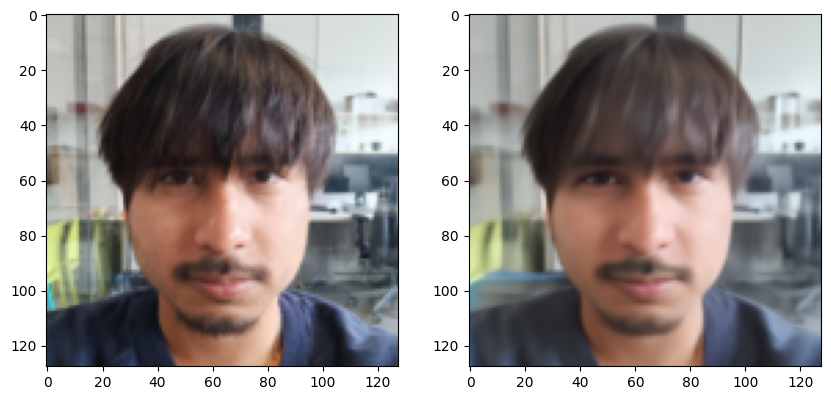

In [17]:
pred = model.render(modified_xT, modified_cond, T=20)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

## Checking semantic space distances

In [37]:
img_x, img_y = data[0]['img'][None], data[2]['img'][None]
img_x, img_y = img_x.to(device), img_y.to(device)

In [38]:
img_x.shape

torch.Size([1, 3, 128, 128])

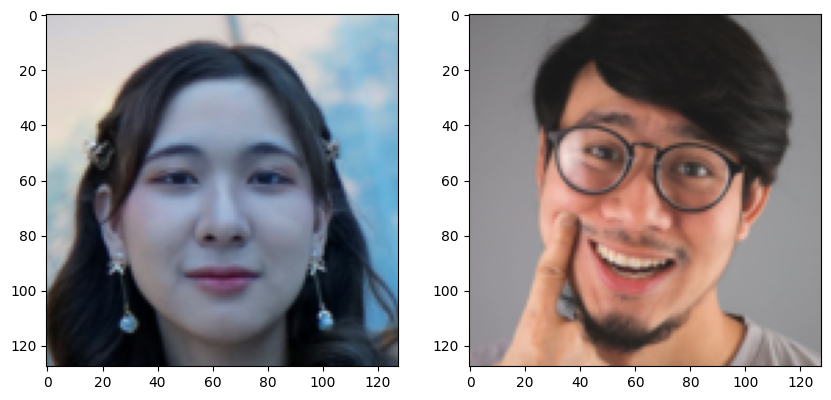

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(img_x[0].permute(1, 2, 0).cpu() / 2 + 0.5)
ax[1].imshow(img_y[0].permute(1, 2, 0).cpu() / 2 + 0.5)

In [44]:
def euclidean_distance(vec1, vec2):
    return np.linalg.norm(np.array(vec1) - np.array(vec2))

In [40]:
cond_x = model.encode(img_x)
cond_y = model.encode(img_y)

In [47]:
print(torch.nn.functional.cosine_similarity(cond_x, cond_y, dim=1))
print(euclidean_distance(cond_x.cpu(), cond_y.cpu()))  

tensor([1.0000], device='cuda:1')
0.04856016


In [48]:
modified_cond_x =  model.ema_model.classifier_component(x = img_x, cond = cond_x)
modified_cond_y =  model.ema_model.classifier_component(x = img_y, cond = cond_y)

In [50]:
print(torch.nn.functional.cosine_similarity(modified_cond_x, modified_cond_y, dim=1))
print(euclidean_distance(modified_cond_x.cpu(), modified_cond_y.cpu()))

tensor([0.9819], device='cuda:1')
0.69302815
